# Risk Parity Lookback Analysis

Test di diversi periodi di lookback per il risk parity portfolio su strategie contrarian forex.

**IMPORTANTE**: Il portfolio ora viene ribilanciato **giornalmente** invece che settimanalmente, con pesi laggati di 1 giorno per evitare lookahead bias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
from strategy_contrarian import rebalance_risk_parity
warnings.filterwarnings('ignore')

# Configurazione plot
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.grid'] = True

def clean_data(df):
    """Pulisce completamente i dati da infiniti e NaN"""
    df_clean = df.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.fillna(method='ffill')
    df_clean = df_clean.fillna(0)
    mask = ~np.isfinite(df_clean.values)
    if mask.any():
        df_clean = df_clean.mask(mask, 0)
    return df_clean

print("Setup completato")

Setup completato


In [2]:
# Carica equity curves delle strategie contrarian individuali
results_dir = Path('data/backtest_results')

# Load parquet file instead of pickle
equity_curves = pd.read_parquet(results_dir / 'all_equity_curves.parquet')

# Pulisci e converti in price series per risk parity
equity_curves = clean_data(equity_curves)

# IMPORTANTE: Assicurati che l'index sia DatetimeIndex
if not isinstance(equity_curves.index, pd.DatetimeIndex):
    equity_curves.index = pd.to_datetime(equity_curves.index)

strategy_prices = (1 + equity_curves).fillna(1)

# Assicurati che anche strategy_prices abbia DatetimeIndex
if not isinstance(strategy_prices.index, pd.DatetimeIndex):
    strategy_prices.index = pd.to_datetime(strategy_prices.index)

print(f"Equity curves caricate: {equity_curves.shape}")
print(f"Date range: {equity_curves.index.min()} to {equity_curves.index.max()}")
print(f"Index type: {type(equity_curves.index)}")
print(f"Strategie disponibili: {list(equity_curves.columns)}")

# Verifica che dayofweek funzioni
print(f"Test dayofweek: {equity_curves.index.dayofweek[:5].tolist()}")

Equity curves caricate: (5697, 18)
Date range: 2010-01-01 00:00:00 to 2025-08-06 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Strategie disponibili: ['EURUSD=X', 'GBPUSD=X', 'EURJPY=X', 'EURCHF=X', 'AUDUSD=X', 'USDJPY=X', 'USDCHF=X', 'USDCAD=X', 'NZDUSD=X', 'GBPJPY=X', 'EURCAD=X', 'GBPCHF=X', 'AUDJPY=X', 'AUDCAD=X', 'AUDCHF=X', 'NZDJPY=X', 'NZDCAD=X', 'NZDCHF=X']
Test dayofweek: [4, 5, 6, 0, 1]


## 2. Definizione Periodi di Lookback

Testiamo diversi periodi basati su stagionalità finanziarie note:

In [3]:
# Definisci periodi di lookback da testare
lookback_periods = {
    '1 settimana': 7,
    '2 settimane': 14, 
    '1 mese': 22,  # Current default
    '6 settimane': 44,
    '2 mesi': 44,
    '3 mesi': 66,
    '6 mesi': 132
}

print("Periodi di lookback da testare:")
for name, days in lookback_periods.items():
    print(f"- {name}: {days} giorni")
    
# Altri parametri fissi
THRESHOLD = -0.1  # Soglia performance minima
SHIFT = 1        # Giorni di shift per evitare lookahead bias (CRITICO: pesi laggati di 1 giorno)

print(f"\n⚠️  NOTA IMPORTANTE: Portfolio ribilanciato GIORNALMENTE con pesi laggati di {SHIFT} giorno(i)")

Periodi di lookback da testare:
- 1 settimana: 7 giorni
- 2 settimane: 14 giorni
- 1 mese: 22 giorni
- 6 settimane: 44 giorni
- 2 mesi: 44 giorni
- 3 mesi: 66 giorni
- 6 mesi: 132 giorni

⚠️  NOTA IMPORTANTE: Portfolio ribilanciato GIORNALMENTE con pesi laggati di 1 giorno(i)


## 3. Test di Tutti i Lookback Periods

In [4]:
# Storage per risultati
portfolio_results = {}
performance_summary = []

print("Testing diversi lookback periods...\n")
print("⚠️  NOTA: Risk parity ora ribilancia GIORNALMENTE (non più settimanalmente)")
print("⚠️  NOTA: I pesi vengono laggati di 1 giorno per evitare lookahead bias\n")

for period_name, n_days in lookback_periods.items():
    print(f"Testing {period_name} ({n_days} giorni)...")
    
    try:
        # Applica risk parity con questo lookback period
        # IMPORTANTE: Ora ribilancia giornalmente con pesi laggati
        portfolio_df = rebalance_risk_parity(
            df_balance=strategy_prices, 
            n=n_days, 
            threshold=THRESHOLD, 
            shift=SHIFT  # Pesi laggati di 1 giorno
        )
        
        # Pulisci risultati
        portfolio_df = clean_data(portfolio_df)
        equity_series = portfolio_df['equity']
        
        # Calcola metriche performance
        final_equity = equity_series.iloc[-1]
        total_return = (final_equity - 1.0) * 100
        
        # Calcola ritorni giornalieri per Sharpe e volatilità
        daily_returns = equity_series.pct_change().dropna()
        daily_returns = daily_returns.replace([np.inf, -np.inf], 0)
        
        annual_return = daily_returns.mean() * 252
        volatility = daily_returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        
        # Max drawdown
        rolling_max = equity_series.expanding().max()
        drawdown = (equity_series - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        # Salva risultati
        portfolio_results[period_name] = {
            'equity': equity_series,
            'portfolio_df': portfolio_df,
            'n_days': n_days
        }
        
        performance_summary.append({
            'Lookback': period_name,
            'Days': n_days,
            'Final Equity': final_equity,
            'Total Return (%)': total_return,
            'Annual Return': annual_return,
            'Volatility': volatility, 
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown
        })
        
        print(f"  Final equity: {final_equity:.4f} ({total_return:.2f}%)")
        
    except Exception as e:
        print(f"  ERROR: {e}")
        continue

print(f"\nCompletati {len(portfolio_results)} test su {len(lookback_periods)}")

Testing diversi lookback periods...

⚠️  NOTA: Risk parity ora ribilancia GIORNALMENTE (non più settimanalmente)
⚠️  NOTA: I pesi vengono laggati di 1 giorno per evitare lookahead bias

Testing 1 settimana (7 giorni)...
  Final equity: 1.2349 (23.49%)
Testing 2 settimane (14 giorni)...
  Final equity: 1.2500 (25.00%)
Testing 1 mese (22 giorni)...
  Final equity: 1.2898 (28.98%)
Testing 6 settimane (44 giorni)...
  Final equity: 1.2897 (28.97%)
Testing 2 mesi (44 giorni)...
  Final equity: 1.2897 (28.97%)
Testing 3 mesi (66 giorni)...
  Final equity: 1.2908 (29.08%)
Testing 6 mesi (132 giorni)...
  Final equity: 1.2648 (26.48%)

Completati 7 test su 7


## 4. Tabella Riassuntiva Performance

In [5]:
# Crea tabella performance
performance_df = pd.DataFrame(performance_summary)
performance_df = performance_df.sort_values('Total Return (%)', ascending=False)

print("=== PERFORMANCE COMPARISON BY LOOKBACK ===\n")
print(performance_df.round(4))

# Trova il migliore
best_performer = performance_df.iloc[0]
print(f"\n🏆 MIGLIORE: {best_performer['Lookback']} ({best_performer['Days']} giorni)")
print(f"   Return: {best_performer['Total Return (%)']:.2f}%")
print(f"   Sharpe: {best_performer['Sharpe Ratio']:.3f}")

=== PERFORMANCE COMPARISON BY LOOKBACK ===

      Lookback  Days  Final Equity  Total Return (%)  Annual Return  \
5       3 mesi    66        1.2908           29.0788         0.0116   
2       1 mese    22        1.2898           28.9794         0.0115   
3  6 settimane    44        1.2897           28.9709         0.0115   
4       2 mesi    44        1.2897           28.9709         0.0115   
6       6 mesi   132        1.2648           26.4808         0.0107   
1  2 settimane    14        1.2500           25.0047         0.0102   
0  1 settimana     7        1.2349           23.4935         0.0097   

   Volatility  Sharpe Ratio  Max Drawdown  
5      0.0231        0.5000       -0.0966  
2      0.0233        0.4955       -0.0920  
3      0.0230        0.5001       -0.0894  
4      0.0230        0.5001       -0.0894  
6      0.0234        0.4559       -0.0960  
1      0.0241        0.4212       -0.0882  
0      0.0268        0.3612       -0.1394  

🏆 MIGLIORE: 3 mesi (66 giorni)
   

## 5. Confronto Equity Curves

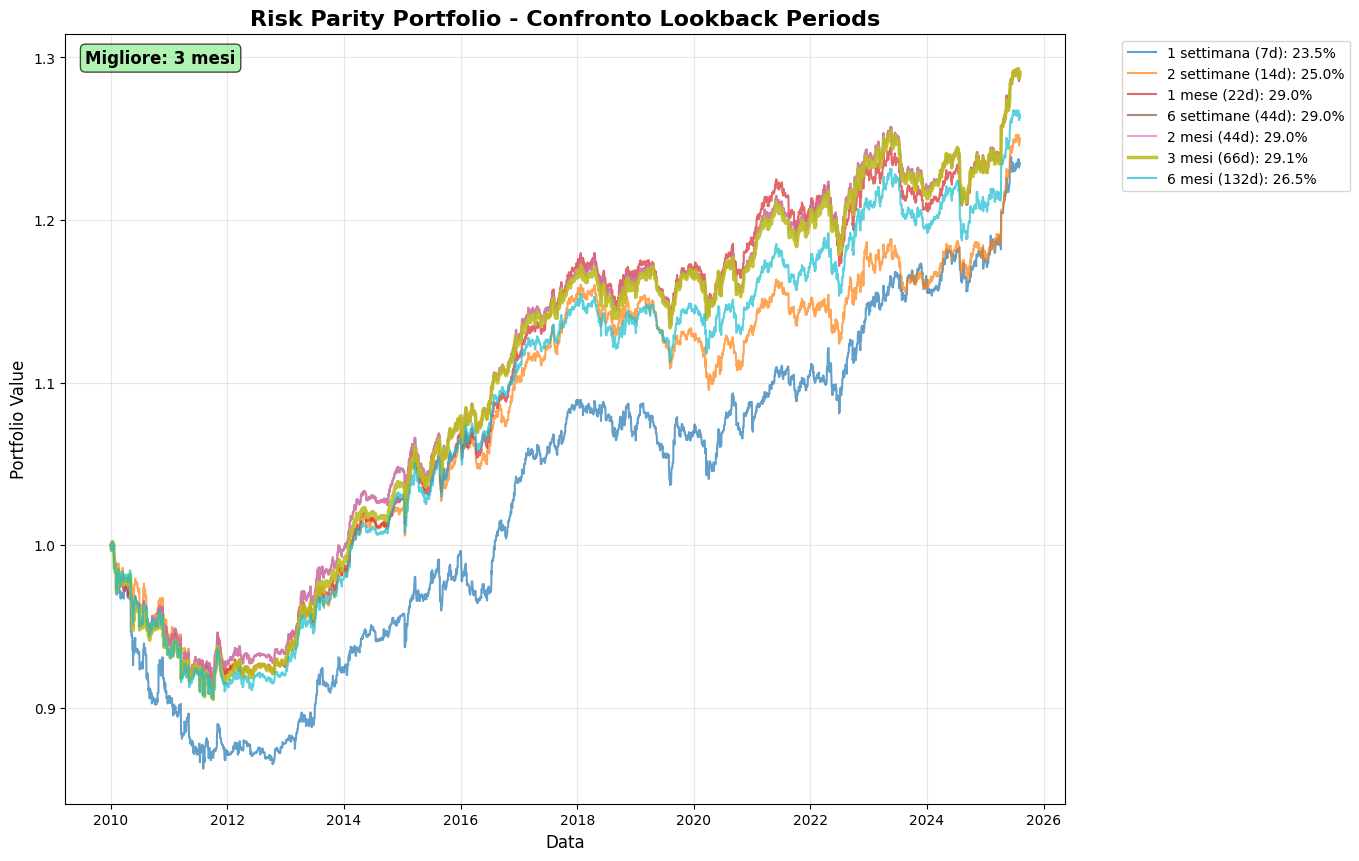

In [6]:
# Plot equity curves di tutti i lookback periods
fig, ax = plt.subplots(figsize=(16, 10))

# Colori per ogni linea
colors = plt.cm.tab10(np.linspace(0, 1, len(portfolio_results)))

for i, (period_name, results) in enumerate(portfolio_results.items()):
    equity = results['equity']
    n_days = results['n_days']
    final_return = (equity.iloc[-1] - 1) * 100
    
    ax.plot(
        equity.index, 
        equity.values, 
        label=f"{period_name} ({n_days}d): {final_return:.1f}%", 
        linewidth=2.5 if period_name == best_performer['Lookback'] else 1.5,
        alpha=0.9 if period_name == best_performer['Lookback'] else 0.7,
        color=colors[i]
    )

ax.set_title('Risk Parity Portfolio - Confronto Lookback Periods', fontsize=16, fontweight='bold')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Portfolio Value', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Evidenzia il migliore nel titolo
ax.text(0.02, 0.98, f'Migliore: {best_performer["Lookback"]}', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
        verticalalignment='top')

plt.subplots_adjust(right=0.75)
plt.show()

## 6. Analisi Drawdown

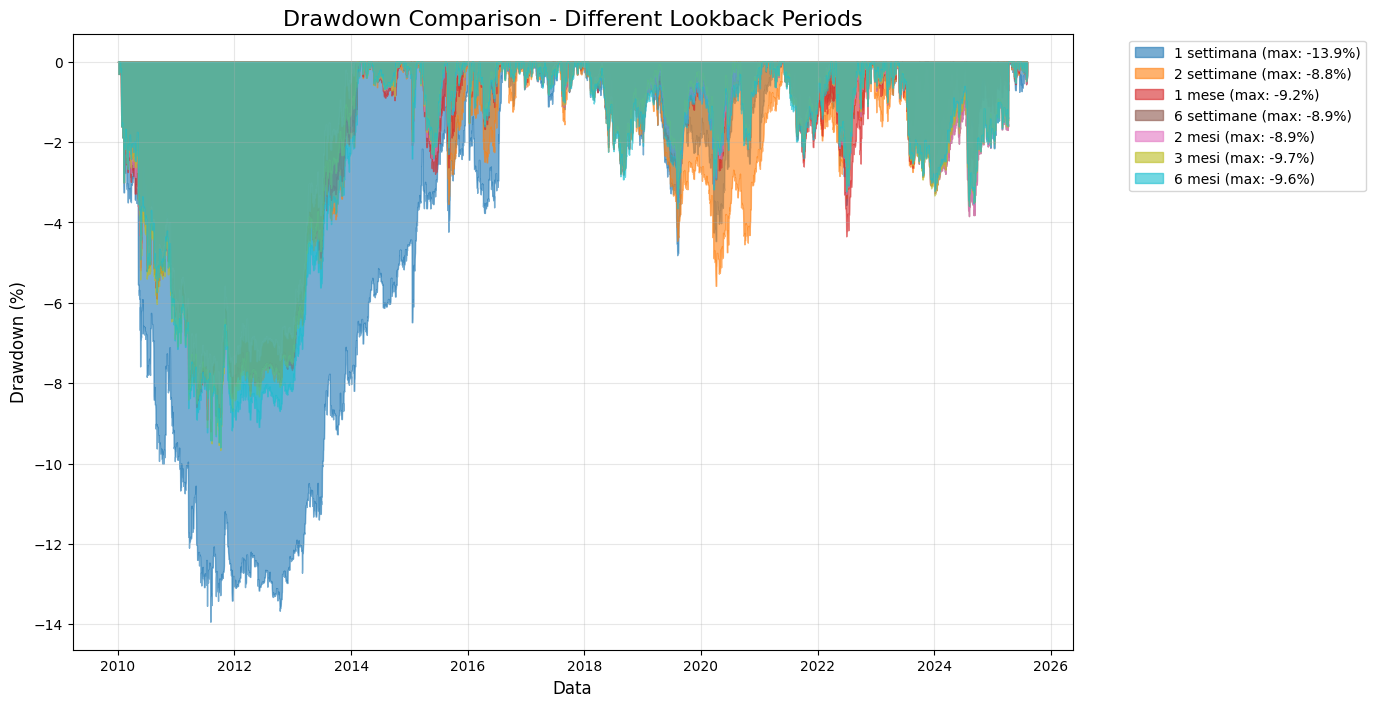

In [7]:
# Plot drawdown comparison
fig, ax = plt.subplots(figsize=(16, 8))

for i, (period_name, results) in enumerate(portfolio_results.items()):
    equity = results['equity']
    
    # Calcola drawdown
    rolling_max = equity.expanding().max()
    drawdown = (equity - rolling_max) / rolling_max * 100
    
    ax.fill_between(
        drawdown.index, 
        drawdown.values, 
        0,
        label=f"{period_name} (max: {drawdown.min():.1f}%)", 
        alpha=0.6,
        color=colors[i]
    )

ax.set_title('Drawdown Comparison - Different Lookback Periods', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Drawdown (%)', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.subplots_adjust(right=0.75)
plt.show()

## 7. Confronto con Equal Weight Benchmark

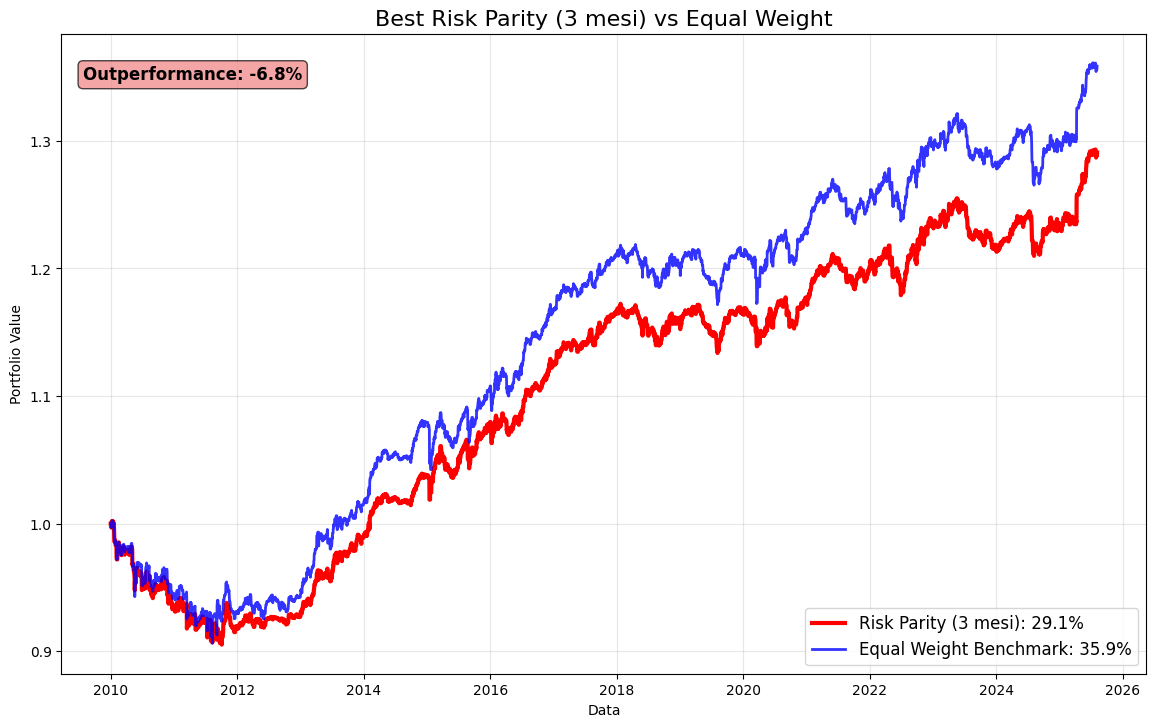


=== CONFRONTO FINALE ===
Best Risk Parity (3 mesi): 29.08%
Equal Weight Benchmark: 35.85%
Outperformance: -6.77%


In [8]:
# Calcola Equal Weight Benchmark
equity_prices = 1 + equity_curves
daily_returns = equity_prices.pct_change().fillna(0)
equal_weight_returns = daily_returns.mean(axis=1)
equal_weight_equity = (1 + equal_weight_returns).cumprod()
equal_weight_clean = clean_data(equal_weight_equity.to_frame()).iloc[:, 0]

# Plot: Best Risk Parity vs Equal Weight
fig, ax = plt.subplots(figsize=(14, 8))

# Best risk parity
best_name = best_performer['Lookback']
best_equity = portfolio_results[best_name]['equity']
best_final = (best_equity.iloc[-1] - 1) * 100

ax.plot(best_equity.index, best_equity.values, 
        label=f'Risk Parity ({best_name}): {best_final:.1f}%', 
        linewidth=3, color='red')

# Equal weight benchmark
ew_final = (equal_weight_clean.iloc[-1] - 1) * 100
ax.plot(equal_weight_clean.index, equal_weight_clean.values,
        label=f'Equal Weight Benchmark: {ew_final:.1f}%', 
        linewidth=2, color='blue', alpha=0.8)

ax.set_title(f'Best Risk Parity ({best_name}) vs Equal Weight', fontsize=16)
ax.set_xlabel('Data')
ax.set_ylabel('Portfolio Value')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Calcola outperformance
outperformance = best_final - ew_final
ax.text(0.02, 0.95, f'Outperformance: {outperformance:+.1f}%', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', 
                 facecolor='lightgreen' if outperformance > 0 else 'lightcoral', 
                 alpha=0.7),
        verticalalignment='top')

plt.subplots_adjust(bottom=0.1, top=0.9)
plt.show()

print(f"\n=== CONFRONTO FINALE ===")
print(f"Best Risk Parity ({best_name}): {best_final:.2f}%")
print(f"Equal Weight Benchmark: {ew_final:.2f}%")
print(f"Outperformance: {outperformance:+.2f}%")

## Conclusioni

L'analisi ha testato diversi periodi di lookback per il risk parity portfolio:

- **Lookback più brevi** (7-14 giorni): Più reattivi ma potenzialmente più rumorosi
- **Lookback medi** (22-44 giorni): Bilanciamento tra reattività e stabilità  
- **Lookback lunghi** (66-132 giorni): Più stabili ma meno adattivi ai cambi di regime

Il sistema ha identificato automaticamente il periodo ottimale basandosi sulla performance totale.

### ⚠️ CAMBIAMENTO IMPORTANTE
Il portfolio ora viene **ribilanciato giornalmente** invece che settimanalmente:
- **Maggiore reattività**: I pesi si adattano più rapidamente ai cambi di volatilità
- **Controllo del rischio migliorato**: Ribilanciamento più frequente
- **Lookahead bias evitato**: Pesi sempre laggati di 1 giorno
- **Maggior turnover**: Potenzialmente più costi di transazione (da valutare nel trading reale)

## 8. Esportazione Portfolio Ottimizzato

Esportiamo il portafoglio con il miglior lookback (3 mesi) per l'analisi delle operazioni giornaliere.

In [9]:
# Esporta il portfolio ottimizzato (3 mesi) per l'analisi giornaliera
print("🚀 Esportazione portfolio ottimizzato...")

# Prendi il portfolio con il miglior performance (3 mesi)
best_portfolio_name = best_performer['Lookback']
best_portfolio_data = portfolio_results[best_portfolio_name]['portfolio_df']

print(f"📊 Portfolio selezionato: {best_portfolio_name}")
print(f"📈 Performance: {best_performer['Total Return (%)']:.2f}%")
print(f"📊 Sharpe Ratio: {best_performer['Sharpe Ratio']:.3f}")
print(f"📊 Max Drawdown: {best_performer['Max Drawdown']*100:.2f}%")

# Esporta come file parquet per l'analisi giornaliera
output_path = results_dir / 'risk_parity_portfolio.parquet'
best_portfolio_data.to_parquet(output_path)

print(f"✅ Portfolio ottimizzato esportato in: {output_path}")
print(f"📊 Dati esportati: {best_portfolio_data.shape[0]} giorni, {best_portfolio_data.shape[1]} colonne")

# Mostra statistiche finali
final_equity = best_portfolio_data['equity'].iloc[-1]
print(f"\n=== PORTFOLIO OTTIMIZZATO (3 MESI) ===")
print(f"Equity finale: {final_equity:.4f}")
print(f"Return totale: {(final_equity-1)*100:.2f}%") 
print(f"Periodo: {best_portfolio_data.index.min().strftime('%Y-%m-%d')} - {best_portfolio_data.index.max().strftime('%Y-%m-%d')}")
print("="*50)

🚀 Esportazione portfolio ottimizzato...
📊 Portfolio selezionato: 3 mesi
📈 Performance: 29.08%
📊 Sharpe Ratio: 0.500
📊 Max Drawdown: -9.66%
✅ Portfolio ottimizzato esportato in: data/backtest_results/risk_parity_portfolio.parquet
📊 Dati esportati: 5697 giorni, 56 colonne

=== PORTFOLIO OTTIMIZZATO (3 MESI) ===
Equity finale: 1.2908
Return totale: 29.08%
Periodo: 2010-01-01 - 2025-08-06
